In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [4]:
! rm -rf ./experiments
! mkdir -p ./experiments

In [5]:
# img_tgt
# nca_tgt
# img_clip
# nca_clip

In [6]:
prompts = [
    # "a red apple;a green apple;a blue apple;a red apple",
    # "a skinny cat;a normal cat;a fat cat;a very very fat cat",
    # "a red apple;a green tree;a cute dog;the yellow sun",
    # "random noise;self-replicating molecules;cells floating in primordial soup;alien animals roaming around",
    
    # "a bustling luscious nature landscape",
    # "an artificial life simulation",
    # "self-replication emerging in an artificial life simulation",
    # "a photo of the emergence of open-ended complexity",
    
]

In [7]:
prompt1 = ';'.join([
        "",
        "a very skinny cat",
        "a skinny cat",
        "a slightly skinny cat",
        "a normal cat",
        "a slightly fat cat",
        "a fat cat",
        "a very fat cat",
    ])
prompt2 = ';'.join([
        "many molecules and chemicals randomly floating around",
        "chemicals coming together to form a cell",
        "a single cell moving around",
        "a cell reproducing to create more cells",
        "many cells moving around",
        "a bustling diverse ecosystem of cells floating around",
        "many cells coming together to form a bigger cell",
        "bigger cells chasing smaller cells in predator-prey like dynamics",
    ])
prompts = [prompt1, prompt2]

In [8]:
prompt1 = "a diverse ecosystem of cells moving around"
prompt2 = ';'.join([
        "many molecules and chemicals randomly floating around",
        "chemicals coming together to form a cell",
        "a single cell moving around",
        "a cell reproducing to create more cells",
        "many cells moving around",
        "a bustling diverse ecosystem of cells floating around",
        "many cells coming together to form a bigger cell",
        "bigger cells chasing smaller cells in predator-prey like dynamics",
    ])
prompts = [prompt1, prompt2]
# prompt = prompt1

In [11]:
cfg_default = dict(
    seed=0, save_dir=None, dtype='float32', device='cuda:0',
    
    img_size=256, d_state=16, perception='fullconv', kernel_size=3, 
    init_state="randn", padding_mode="circular", dt=0.01, dropout=0.5,
    
    target_img_path=None, prompt="a diverse ecosystem of cells moving around", augs="crop+pers", aug_crop_scale=1., clip_model="clip-vit-base-patch32",
    coef_alignment=1., coef_softmax=0., coef_novelty=0., coef_temporal=0.,
    
    rollout_steps=1024, bptt_steps=16, pool_size=1024,
    bs=8, lr=3e-4, n_iters=200000, clip_grad_norm=1.
)

cfgs = []


coef_alignments = [0] + [1]*7
coef_noveltys = [1, 0] + np.logspace(-2, 0.5, 6).tolist()


seeds = np.arange(1)
for seed in seeds:
    for i1, (coef_a, coef_n) in enumerate(zip(coef_alignments, coef_noveltys)):
        cfg = cfg_default.copy()
        cfg.update(seed=seed, coef_alignment=coef_a, coef_novelty=coef_n)
        cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/nca_exp4/{seed=}_{i1=}")
        print(coef_a, coef_n)
        cfgs.append(cfg)


0 1
1 0
1 0.01
1 0.03162277660168379
1 0.09999999999999999
1 0.31622776601683794
1 1.0
1 3.162277660168379


In [12]:
commands = experiment_utils.create_commands(cfgs, prefix='python nca_multi_prompt_clip.py', out_file='./experiments/main.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python nca_multi_prompt_clip.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/nca_exp4/seed=0_i1=0" --dtype="float32" --device="cuda:0" --img_size=256 --d_state=16 --perception="fullconv" --kernel_size=3 --init_state="randn" --padding_mode="circular" --dt=0.01 --dropout=0.5 --target_img_path=None --prompt="a diverse ecosystem of cells moving around" --augs="crop+pers" --aug_crop_scale=1.0 --clip_model="clip-vit-base-patch32" --coef_alignment=0 --coef_softmax=0.0 --coef_novelty=1                   --coef_temporal=0.0 --rollout_steps=1024 --bptt_steps=16 --pool_size=1024 --bs=8 --lr=0.0003 --n_iters=200000 --clip_grad_norm=1.0
python nca_multi_prompt_clip.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/nca_exp4/seed=0_i1=1" --dtype="float32" --device="cuda:0" --img_size=256 --d_state=16 --perception="fullconv" --kernel_size=3 --init_state="randn" --padding_mode="circular" --dt=0.01 --dropout=0.5 --target_img_path=None --prompt="a diverse ecosystem of cells moving

# Visualize Results

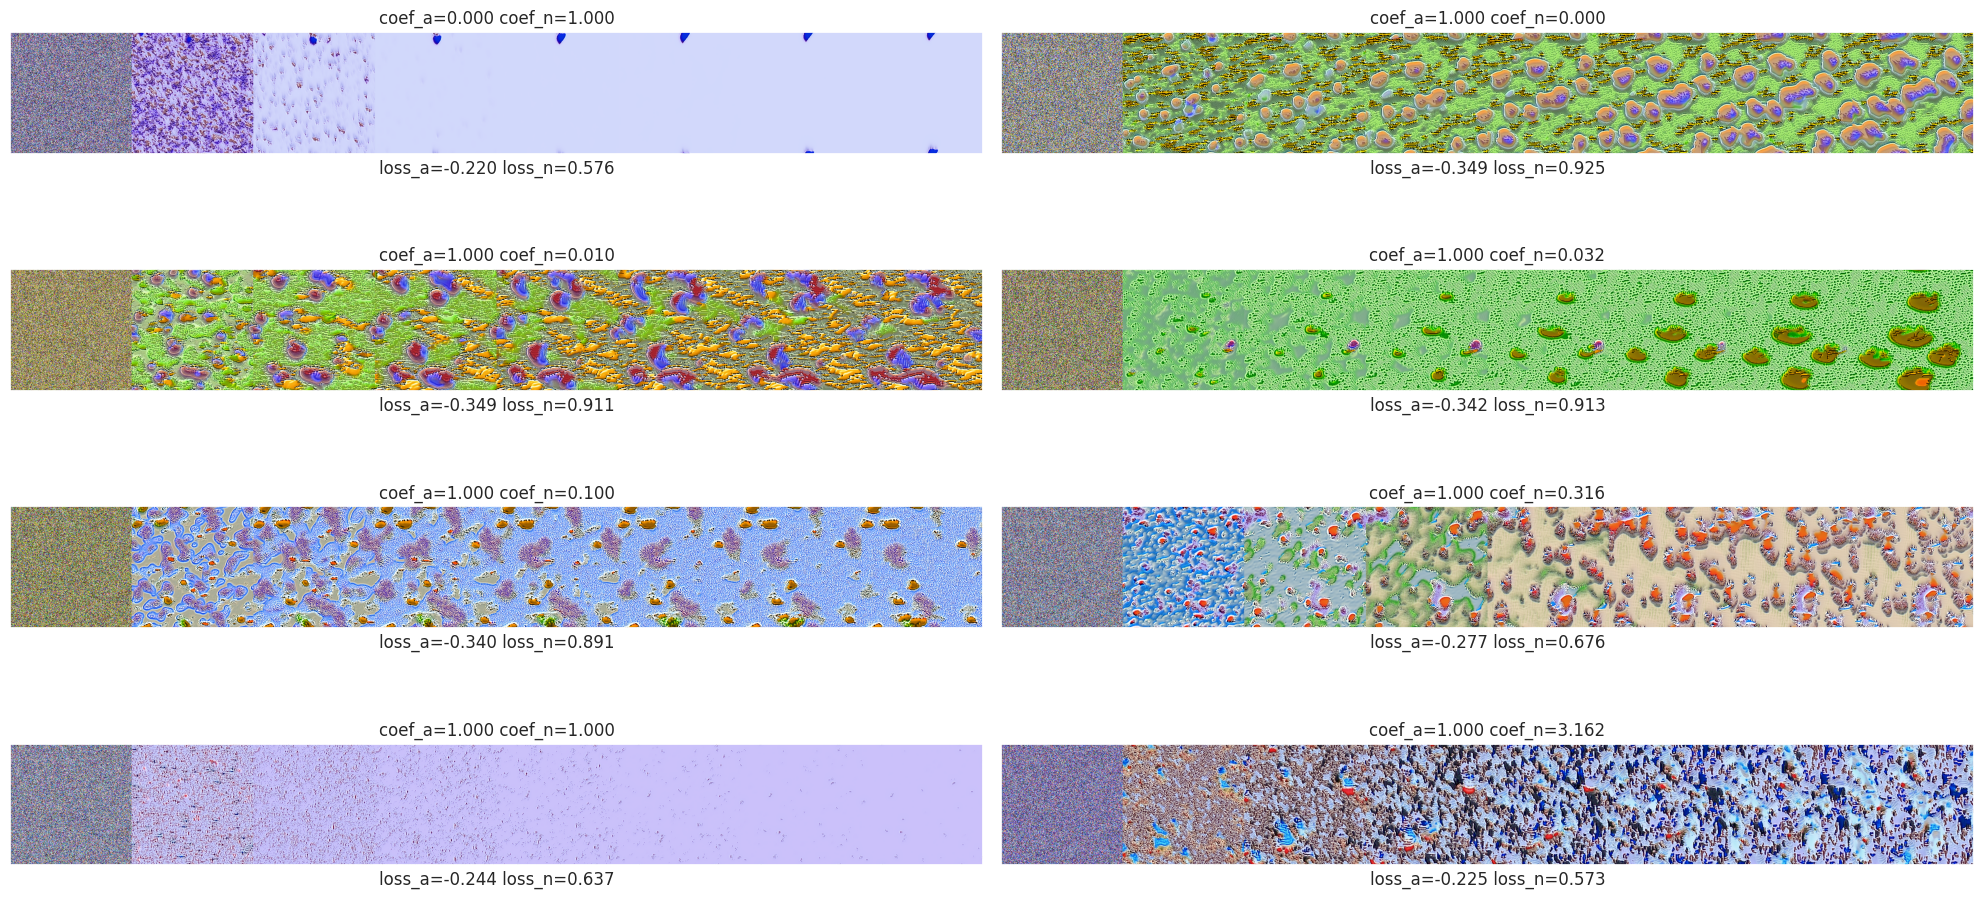

In [52]:
plt.figure(figsize=(20, 10))

iplt = 0
seed = 0
for i1, (coef_a, coef_n) in enumerate(zip(coef_alignments, coef_noveltys)):
    save_dir=f"/home/akarshkumar0101/nca-alife-data/nca_exp4/{seed=}_{i1=}"
    
    iplt+=1
    plt.subplot(4, 2, iplt)
    vid = util.load_pkl(save_dir, 'vid').astype(np.uint8)
    losses = util.load_pkl(save_dir, 'losses')
    loss_a, loss_n = losses['loss_alignment'][-50000:].mean(), losses['loss_novelty'][-50000:].mean()
    plt.imshow(rearrange(vid[::vid.shape[0]//8], 'T H W D -> H (T W) D'))
    plt.grid(False)
    plt.xticks([]); plt.yticks([])
    plt.title(f'{coef_a=:.3f} {coef_n=:.3f}')
    plt.xlabel(f'{loss_a=:.3f} {loss_n=:.3f}')
    
plt.tight_layout()
plt.show()

In [39]:
df = []
for i1, (coef_a, coef_n) in enumerate(zip(coef_alignments, coef_noveltys)):
    save_dir=f"/home/akarshkumar0101/nca-alife-data/nca_exp4/{seed=}_{i1=}"
    losses = util.load_pkl(save_dir, 'losses')
    df.append(losses['loss'])
df = pd.DataFrame(np.stack(df)).T

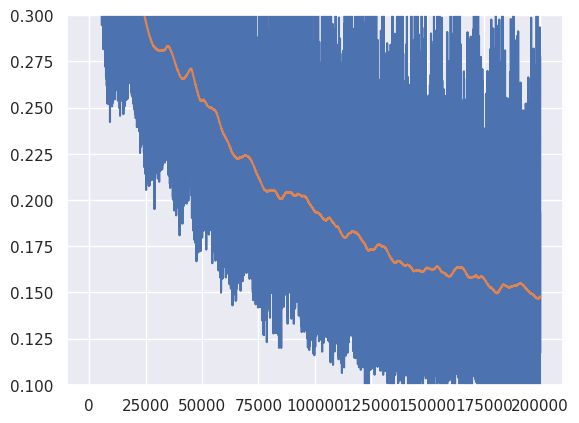

In [51]:
df.ewm(span=1).mean().mean(axis=1).plot(ax=plt.gca())
df.ewm(span=10000).mean().mean(axis=1).plot(ax=plt.gca())
plt.ylim(0.1, 0.3)
plt.show()


In [6]:
a = util.load_pkl(f"./temp2", "fitnesses")
a = np.stack(a)

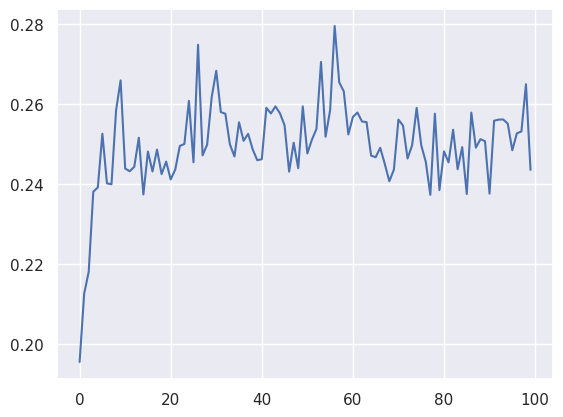

In [14]:
plt.plot(a.max(axis=-1)[:100])